<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<!-- TODO(b/319266067) remove temporary advert after a few weeks. -->
<div class="markdown-google-sans">
  <h2>(New) Try the Gemini API</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/google-gemini/gemini-api-cookbook/blob/main/examples/Market_a_Jet_Backpack.ipynb?utm_medium=link&utm_campaign=gemini">Create a marketing campaign from a product sketch of a Jet Backpack</a></li>
  <li><a href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/python_quickstart.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API: Quickstart with Python</a></li>
  <li><a href="https://colab.research.google.com/notebooks/snippets/gemini.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API code sample</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:

# Load dataset
!wget https://raw.githubusercontent.com/Sid2728/CL653_dataset/main/country_seep_data_filtered.csv
dataset = pd.read_csv('country_seep_data_filtered.csv')

# Drop unnecessary columns
dataset = dataset.drop(['Seep_Name', 'Basin'], axis=1)

--2024-04-25 11:38:19--  https://raw.githubusercontent.com/Sid2728/CL653_dataset/main/country_seep_data_filtered.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344743 (337K) [text/plain]
Saving to: ‘country_seep_data_filtered.csv’

country_seep_data_f 100%[===================>] 336.66K  --.-KB/s    in 0.04s   

2024-04-25 11:38:20 (9.04 MB/s) - ‘country_seep_data_filtered.csv’ saved [344743/344743]



,Country,Longitude,Latitude,Seep_Type,CH4_Concentration,C2_Concentration,C3_Concentration,Delta13C1,DeltaD1,Bernard_Ratio
0,Zambia,30.4693,33.8383,Oil,6.9,0.2,93.5,-29.1,-204,1.5
1,Kuwait,111.0199,21.4265,Gas,6.1,0.2,93.5,-29.5,-202,1.4
2,Vietnam,-72.6717,-22.5716,Oil,6.5,0.2,93.5,-29.3,-199,1.3
3,Iraq,50.2043,56.2245,Oil,7.0,0.3,93.5,-29.5,-201,1.4
4,Canada,-90.8495,30.3595,Oil,6.8,0.3,92.7,-29.5,-199,1.5


In [3]:
# Encode categorical variables
le = LabelEncoder()
dataset['Seep_Type'] = le.fit_transform(dataset['Seep_Type'])
dataset = pd.get_dummies(dataset, columns=['Country'])

# Split dataset into features and target variable
X = dataset.drop('Seep_Type', axis=1)
y = dataset['Seep_Type']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=81)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=81)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize MLPClassifier
mlp = MLPClassifier(max_iter=1000, random_state=81)

# Define parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(8,), (8, 4), (10, 5)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train model with best parameters
best_mlp = MLPClassifier(max_iter=1000, random_state=81, **best_params)
best_mlp.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = best_mlp.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (8, 4), 'solver': 'adam'}
Accuracy: 0.50375

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       390
           1       0.52      0.48      0.50       410

    accuracy                           0.50       800
   macro avg       0.50      0.50      0.50       800
weighted avg       0.50      0.50      0.50       800



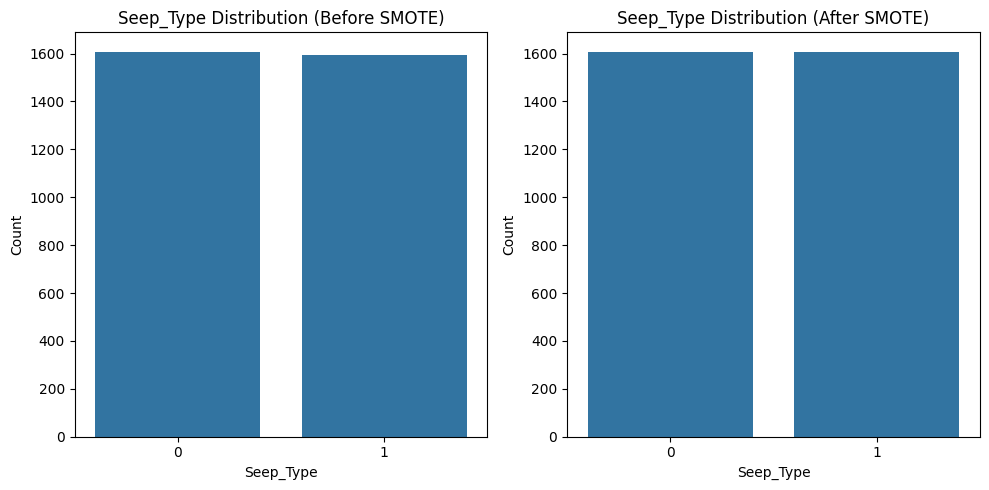

In [6]:

# Plot Seep_Type distribution before and after SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Seep_Type', data=pd.DataFrame(y_train, columns=['Seep_Type']))
plt.title('Seep_Type Distribution (Before SMOTE)')
plt.xlabel('Seep_Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Seep_Type Distribution (After SMOTE)')
plt.xlabel('Seep_Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

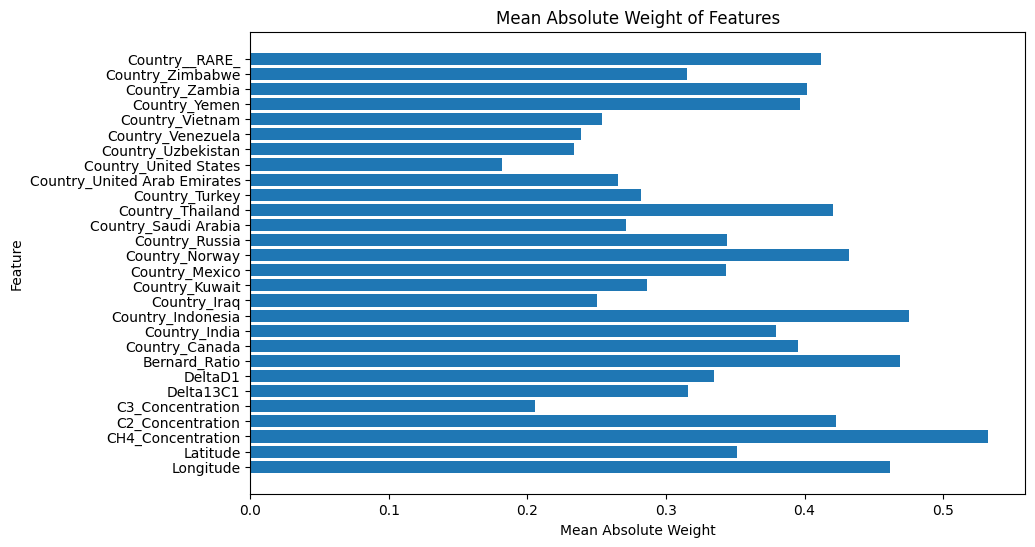

In [15]:
if hasattr(best_mlp, 'coefs_'):
    coefs = best_mlp.coefs_[0]  # Get weights connecting input features to first hidden layer
    feature_names = X.columns
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_names)), np.abs(coefs).mean(axis=1), align='center')  # Transpose coefs and take mean along rows
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('Mean Absolute Weight')
    plt.ylabel('Feature')
    plt.title('Mean Absolute Weight of Features')
    plt.show()


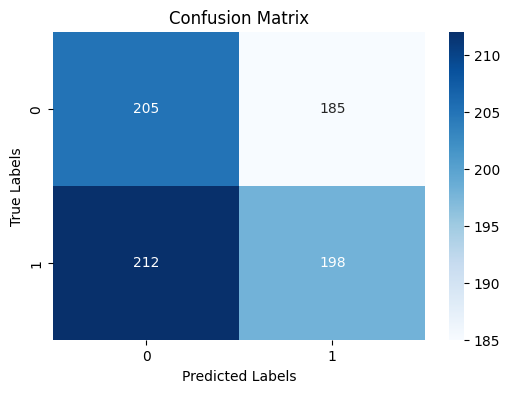

In [8]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

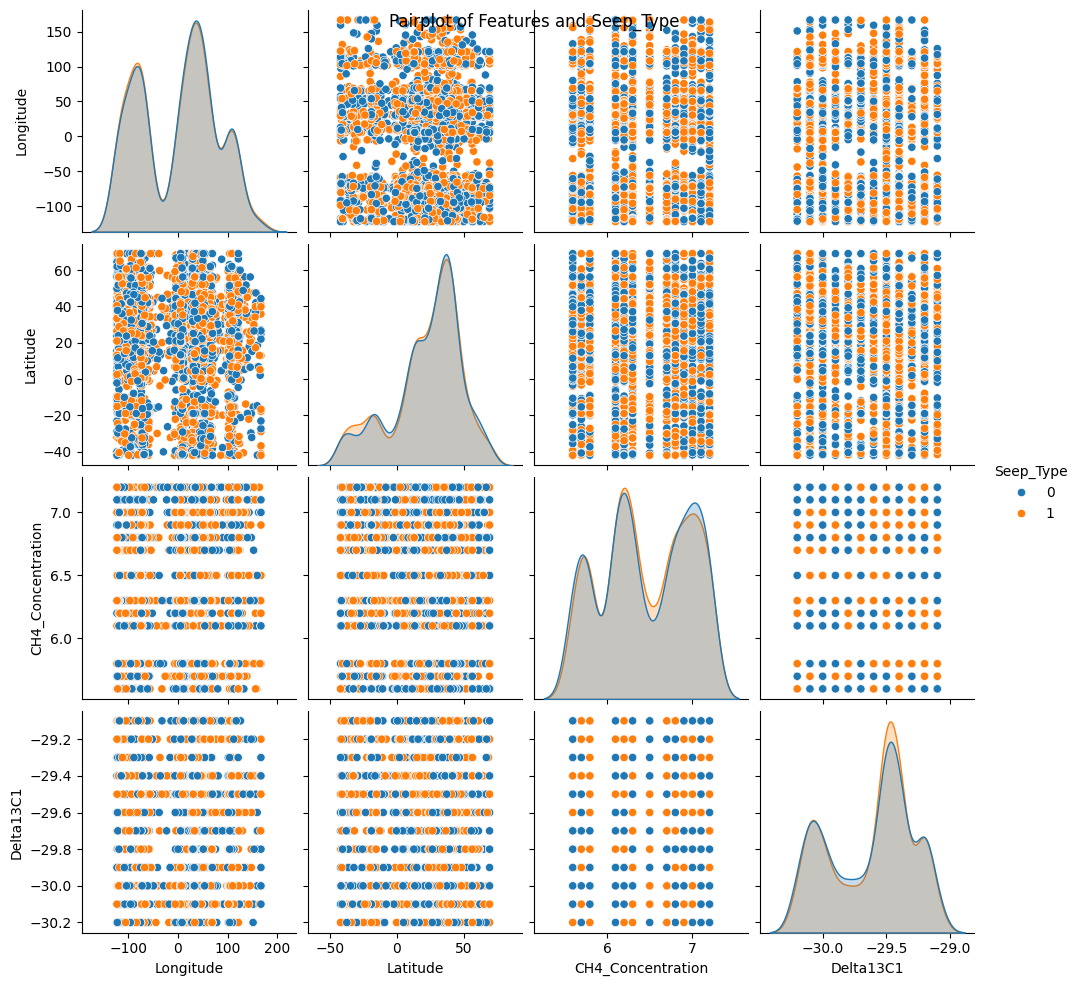

In [11]:
# Pairplot
sns.pairplot(dataset[['Longitude', 'Latitude', 'CH4_Concentration', 'Delta13C1', 'Seep_Type']], hue='Seep_Type', diag_kind='kde')
plt.suptitle("Pairplot of Features and Seep_Type")
plt.show()

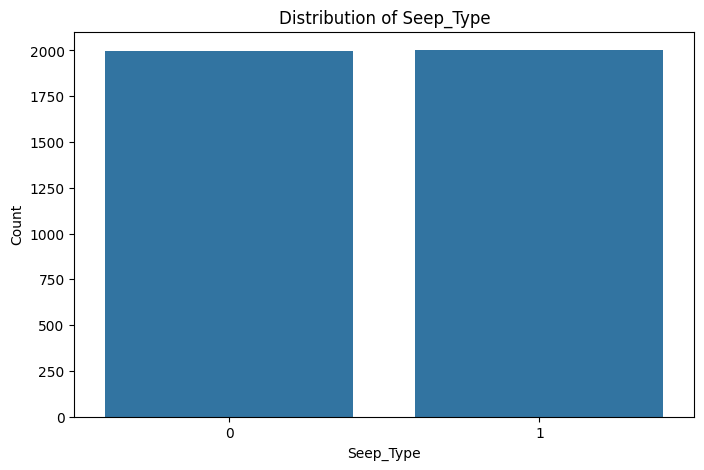

In [9]:
# Barplot of Seep_Type
plt.figure(figsize=(8, 5))
sns.countplot(x='Seep_Type', data=dataset)
plt.title('Distribution of Seep_Type')
plt.xlabel('Seep_Type')
plt.ylabel('Count')
plt.show()

<ipython-input-10-5d5a4cd57937>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Seep_Type', y='Delta13C1', data=dataset, palette='Set2')


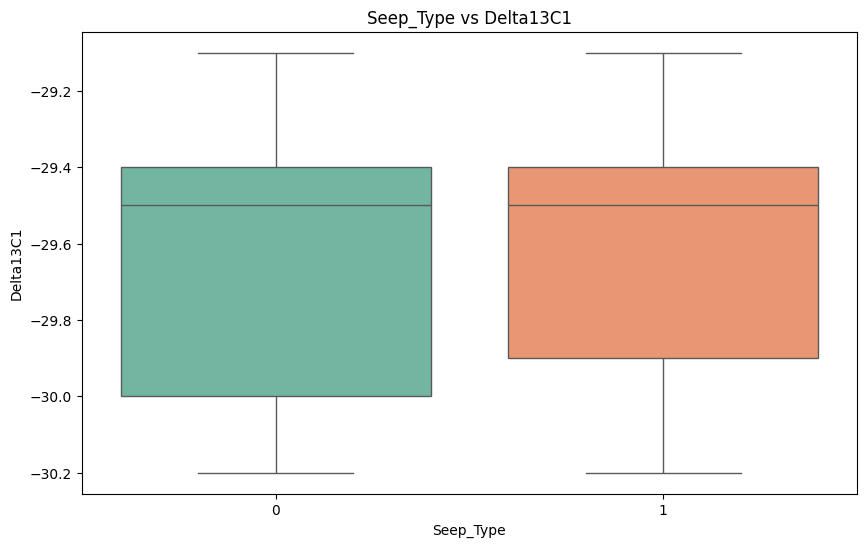

In [10]:
# Boxplot of Seep_Type and Delta13C1
plt.figure(figsize=(10, 6))
sns.boxplot(x='Seep_Type', y='Delta13C1', data=dataset, palette='Set2')
plt.title('Seep_Type vs Delta13C1')
plt.xlabel('Seep_Type')
plt.ylabel('Delta13C1')
plt.show()

If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view, and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  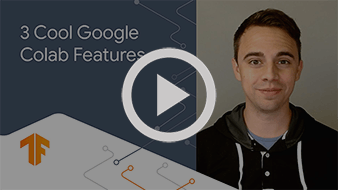
  </a>
</center>